# word2vec 작성

- skipgram, window size 2 의 simplified word2vec model 작성

<img src="https://i.imgur.com/fr5B4on.jpeg" width=500 />

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Toy 말뭉치

In [2]:
corpus = [
    "king is a very strong man",
    "queen is a wise and pretty woman",
    "boy is a young man",
    "girl is a young and pretty woman",
    "prince is young and will be a strong and wise king",
    "princess is a young woman and will be a pretty and wise queen",
    "man is strong",
    "woman is pretty",
    "prince is a boy and will be a king",
    "princess is a girl and will be a queen",
    "a king is powerful and strong",
    "a queen is beautiful and intelligent",
    "a boy is a youthful male",
    "a girl is a youthful and lovely female",
    "a prince is a young and smart future king",
    "a princess is a young and graceful future queen",
    "a king has power and strength",
    "a queen has wisdom and charm",
    "a prince will rule as a king one day",
    "a princess will become a queen in the future",
    "a king and a queen rule the kingdom",
    "a prince and a princess are part of the royal family",
    "a boy grows up to be a man",
    "a girl grows up to be a woman",
    "a strong man can become a king",
    "a wise woman can become a queen",
    "kings and queens live in castles",
    "princes and princesses are members of the royal family",
    "a man and a woman can both be leaders",
    "a young boy dreams of becoming a king",
    "a young girl dreams of becoming a queen"
]

In [3]:
# 텍스트 전처리

# 불용어 리스트 (제거할 단어 목록)
stop_words = ['is', 'a', 'will', 'be', 'and', 'are', 'to', 'as', 'the', 'in', 'has', 'up', 'can', 'of']

# 전처리된 문장을 저장할 리스트
cleaned_corpus = []

# corpus에 있는 각 문장에 대해 반복
for text in corpus:
    text = re.sub(r'[^a-zA-Z ]', '', text).lower()    # 영문자와 공백을 제외한 문자 제거 후 소문자로 변환
    words = [word for word in text.split() if word not in stop_words]  # 불용어 제거
    cleaned_corpus.append(words)       # 전처리된 단어 리스트를 저장

# 전처리된 텍스트 출력
cleaned_corpus

[['king', 'very', 'strong', 'man'],
 ['queen', 'wise', 'pretty', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'pretty', 'woman'],
 ['prince', 'young', 'strong', 'wise', 'king'],
 ['princess', 'young', 'woman', 'pretty', 'wise', 'queen'],
 ['man', 'strong'],
 ['woman', 'pretty'],
 ['prince', 'boy', 'king'],
 ['princess', 'girl', 'queen'],
 ['king', 'powerful', 'strong'],
 ['queen', 'beautiful', 'intelligent'],
 ['boy', 'youthful', 'male'],
 ['girl', 'youthful', 'lovely', 'female'],
 ['prince', 'young', 'smart', 'future', 'king'],
 ['princess', 'young', 'graceful', 'future', 'queen'],
 ['king', 'power', 'strength'],
 ['queen', 'wisdom', 'charm'],
 ['prince', 'rule', 'king', 'one', 'day'],
 ['princess', 'become', 'queen', 'future'],
 ['king', 'queen', 'rule', 'kingdom'],
 ['prince', 'princess', 'part', 'royal', 'family'],
 ['boy', 'grows', 'man'],
 ['girl', 'grows', 'woman'],
 ['strong', 'man', 'become', 'king'],
 ['wise', 'woman', 'become', 'queen'],
 ['kings', 'queens', 'live'

### vocaburary 모음 작성

### word-to-index, index-to-word 작성

- word 를 index 로 변환  

- sentence 를 word index 로 변환  

- window size 에 따라 train data 생성

In [4]:
# 단어 사전 만들기

# `cleaned_corpus`에서 모든 단어를 집합(set)으로 저장하여 중복 제거
vocab = set(word for sentence in cleaned_corpus for word in sentence)

# 단어를 고유한 인덱스로 매핑 (word → index)
word2index = {word: i for i, word in enumerate(vocab)}

# 인덱스를 단어로 매핑 (index → word)
index2word = {i: word for word, i in word2index.items()}

# 전체 단어 사전의 크기
vocab_size = len(vocab)
vocab_size

47

### skip-gram 으로 training data 생성

In [5]:
# Skip-gram 데이터 생성

WINDOW_SIZE = 2  # 주변 단어를 고려할 윈도우 크기
data = []          # (중심 단어, 주변 단어) 쌍을 저장할 리스트

# `cleaned_corpus`의 각 문장에 대해 반복
for sentence in cleaned_corpus:
    for idx, word in enumerate(sentence):  # 문장에서 각 단어의 인덱스를 순회
        # 중심 단어를 기준으로 WINDOW_SIZE 내의 주변 단어들을 가져옴
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0): min(idx + WINDOW_SIZE + 1, len(sentence))]:
            if word != neighbor:         # 중심 단어와 주변 단어가 같지 않을 경우에만 추가
                data.append((word2index[word], word2index[neighbor]))   # (중심 단어, 주변 단어) 인덱스 저장

print(data)

[(38, 39), (38, 34), (39, 38), (39, 34), (39, 2), (34, 38), (34, 39), (34, 2), (2, 39), (2, 34), (13, 43), (13, 6), (43, 13), (43, 6), (43, 11), (6, 13), (6, 43), (6, 11), (11, 43), (11, 6), (3, 15), (3, 2), (15, 3), (15, 2), (2, 3), (2, 15), (20, 15), (20, 6), (15, 20), (15, 6), (15, 11), (6, 20), (6, 15), (6, 11), (11, 15), (11, 6), (32, 15), (32, 34), (15, 32), (15, 34), (15, 43), (34, 32), (34, 15), (34, 43), (34, 38), (43, 15), (43, 34), (43, 38), (38, 34), (38, 43), (36, 15), (36, 11), (15, 36), (15, 11), (15, 6), (11, 36), (11, 15), (11, 6), (11, 43), (6, 15), (6, 11), (6, 43), (6, 13), (43, 11), (43, 6), (43, 13), (13, 6), (13, 43), (2, 34), (34, 2), (11, 6), (6, 11), (32, 3), (32, 38), (3, 32), (3, 38), (38, 32), (38, 3), (36, 20), (36, 13), (20, 36), (20, 13), (13, 36), (13, 20), (38, 31), (38, 34), (31, 38), (31, 34), (34, 38), (34, 31), (13, 19), (13, 22), (19, 13), (19, 22), (22, 13), (22, 19), (3, 4), (3, 18), (4, 3), (4, 18), (18, 3), (18, 4), (20, 4), (20, 23), (4, 20),

In [6]:
# Skip-gram 데이터 (인덱스 → 단어)로 변환하여 출력
skip_gram_samples = [(index2word[center], index2word[context]) for center, context in data]

# 결과 출력 (처음 10개만 확인)
for sample in skip_gram_samples[:10]:
    print(sample)

('king', 'very')
('king', 'strong')
('very', 'king')
('very', 'strong')
('very', 'man')
('strong', 'king')
('strong', 'very')
('strong', 'man')
('man', 'very')
('man', 'strong')


In [7]:
# PyTorch Tensor 데이터셋 변환

# `data` 리스트에서 입력 단어(중심 단어)와 정답 단어(주변 단어)를 각각 분리
inputs, labels = zip(*data)

# 리스트를 PyTorch Tensor로 변환 (정수형 LongTensor)
inputs = torch.tensor(inputs, dtype=torch.long).to(device)  # 입력 데이터 (중심 단어)
labels = torch.tensor(labels, dtype=torch.long).to(device)  # 정답 데이터 (주변 단어)

**시각화를 위해 hidden layer 의 unit 을 2 로 제한**

In [8]:
# Word2Vec 모델 정의 (Skip-gram 방식)
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # 단어를 임베딩 벡터로 변환
        self.fc = nn.Linear(embedding_dim, vocab_size)   # 임베딩 벡터를 단어 분포로 변환하는 출력층

    def forward(self, x):
        x = self.embedding(x)  # 입력 단어를 임베딩 벡터로 변환 (batch_size, embedding_dim)
        x = self.fc(x)    # 임베딩 벡터를 vocabulary 크기의 출력 벡터로 변환 (batch_size, vocab_size)
        return x

# 모델 및 학습 설정
embedding_dim = 2  # 시각화를 위해 2차원 벡터 사용
model = Word2Vec(vocab_size, embedding_dim).to(device)

criterion = nn.CrossEntropyLoss()           # 다중 클래스 분류를 위한 손실 함수 (Softmax 포함)
optimizer = optim.Adam(model.parameters(), lr=0.01)    # Adam 옵티마이저 사용 (학습률 0.01)

In [9]:
# 모델 학습

epochs = 500  # 총 학습 반복 횟수
batch_size = 3  # 미니배치 크기

for epoch in range(epochs):
    total_loss = 0  # 한 epoch 동안의 총 손실 초기화
    indices = torch.randperm(len(inputs))  # 데이터 셔플링을 위한 랜덤 인덱스 생성

    # 미니배치 단위로 학습 진행
    for i in range(0, len(inputs), batch_size):
        batch_idx = indices[i: i + batch_size]  # 현재 배치의 인덱스 선택
        batch_inputs = inputs[batch_idx]  # 배치 입력 데이터 (중심 단어)
        batch_labels = labels[batch_idx]  # 배치 정답 데이터 (주변 단어)

        optimizer.zero_grad()  # 이전 미니배치의 그래디언트 초기화
        output = model(batch_inputs)  # 모델 예측값 계산
        loss = criterion(output, batch_labels)  # 손실 함수 (CrossEntropyLoss) 계산
        loss.backward()  # 역전파를 통해 그래디언트 계산
        optimizer.step()  # 옵티마이저를 이용해 가중치 업데이트

        total_loss += loss.item()  # 총 손실 누적

    # 일정 간격마다 손실 값 출력
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 0, Loss: 391.0149
Epoch 50, Loss: 270.9110
Epoch 100, Loss: 262.6621
Epoch 150, Loss: 260.5920
Epoch 200, Loss: 260.7146
Epoch 250, Loss: 260.8113
Epoch 300, Loss: 260.0299
Epoch 350, Loss: 259.5991
Epoch 400, Loss: 259.4974
Epoch 450, Loss: 260.5761


In [11]:
import pandas as pd

# 학습된 단어 벡터 추출
# 모델의 임베딩 층에서 학습된 단어 벡터 가져오기
word_vectors = model.embedding.weight.detach().cpu().numpy()

# 단어 벡터를 DataFrame 형태로 변환 (각 단어를 2차원 좌표로 저장)
w2v_df = pd.DataFrame(word_vectors, columns=['x1', 'x2'])

# 각 벡터에 해당하는 단어 추가
w2v_df['word'] = [index2word[i] for i in range(vocab_size)]
w2v_df.head()

,x1,x2,word
0,9.007575,-6.059137,day
1,1.762615,-1.081899,smart
2,1.114211,0.523733,man
3,1.201074,0.464064,boy
4,0.666399,5.518816,youthful


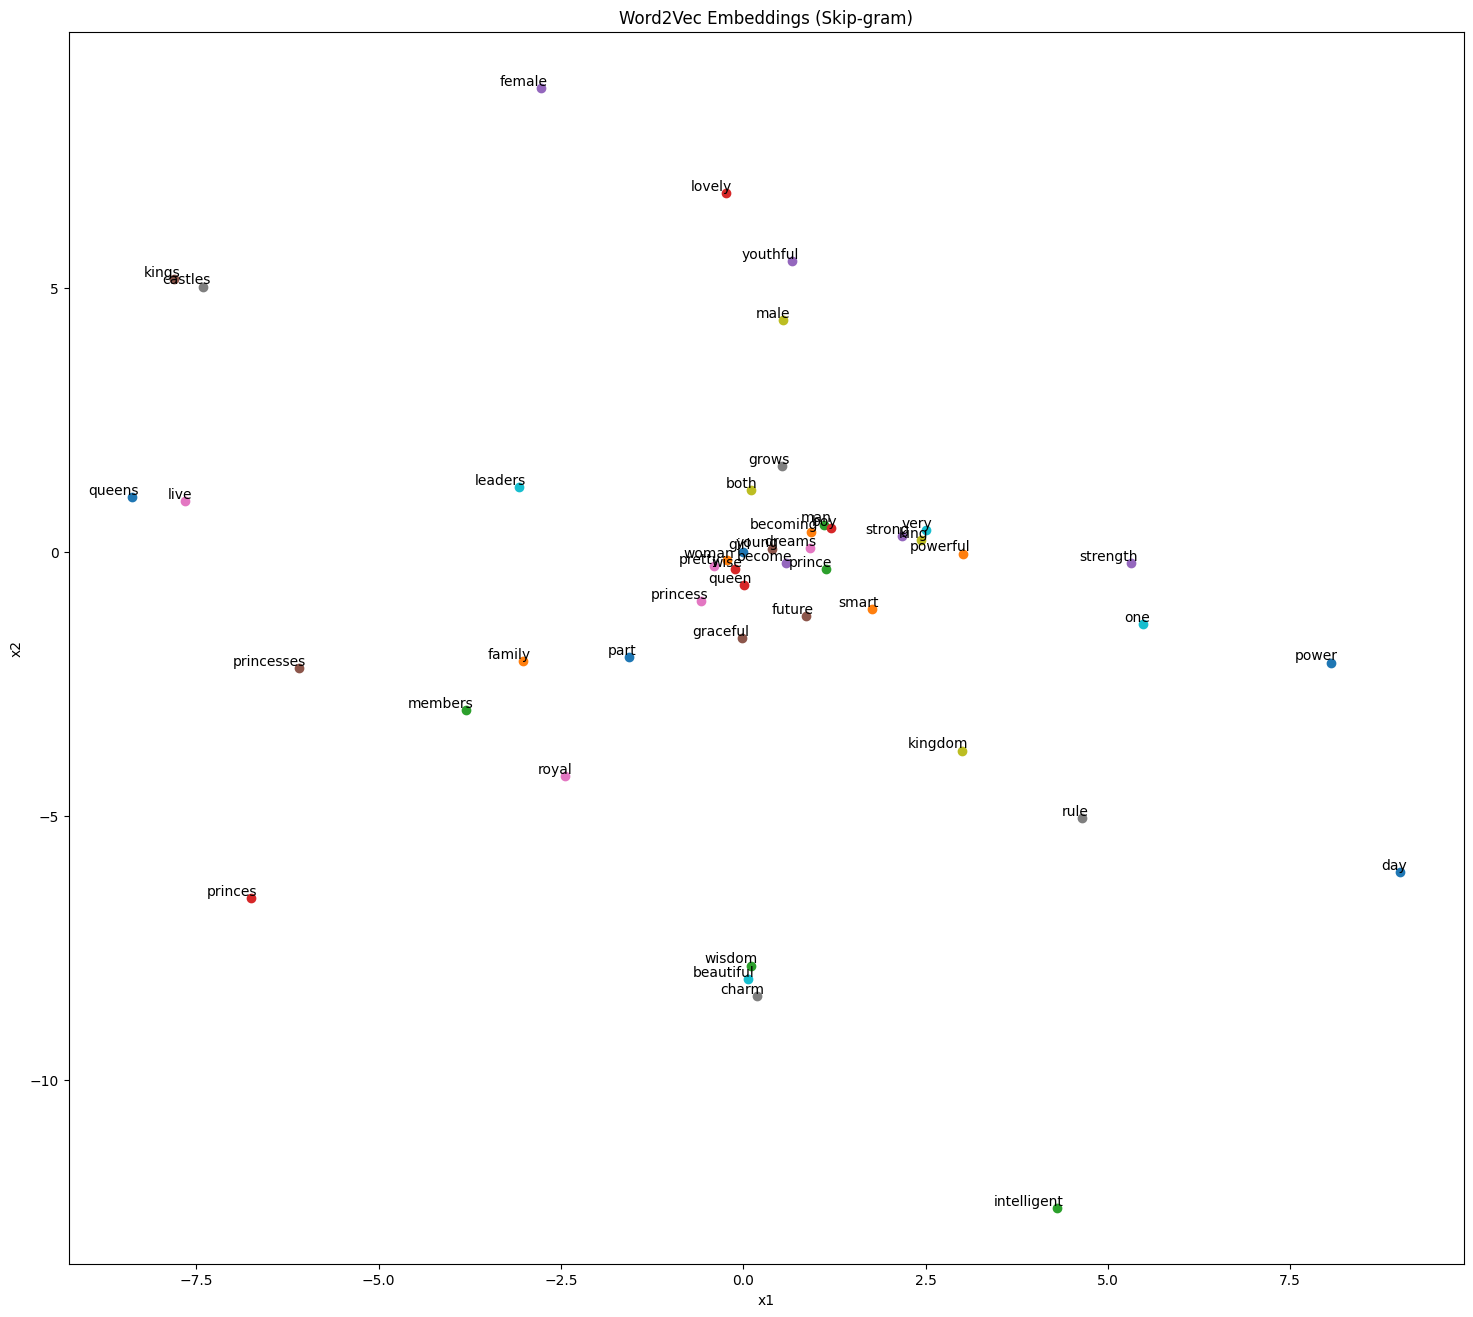

In [12]:
# 벡터 시각화
fig, ax = plt.subplots(figsize=(18, 16))

# 각 단어를 그래프에 표시
for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.scatter(x1, x2)  # 단어 벡터의 위치에 점(산점도) 표시
    ax.annotate(word, (x1, x2), textcoords="offset points", xytext=(5, 2), ha='right')
    # 단어 이름을 점 옆에 표시 (오른쪽 정렬)

# 그래프 라벨 및 제목 추가
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Word2Vec Embeddings (Skip-gram)")  # 그래프 제목

plt.show()